In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import astropy
import os
import pandas as pd
import xlsxwriter
import matplotlib as mpl

from astropy import io
from astropy.io import fits
from astropy import table
from astropy import wcs
from skimage.transform import resize
from astropy.stats import sigma_clipped_stats

### Load Images

In [2]:
good_image = '/home/verlon/Desktop/Astronomaly/Data/Input/Good Images/cutout_23.3816_-6.8632.fits'

In [3]:
bad_image = '/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/cutout_23.7486_-6.3234.fits'

In [4]:
good_image_data = fits.getdata(good_image)

bad_image_data = fits.getdata(bad_image)

In [5]:
bad_image_data.shape

(3, 256, 256)

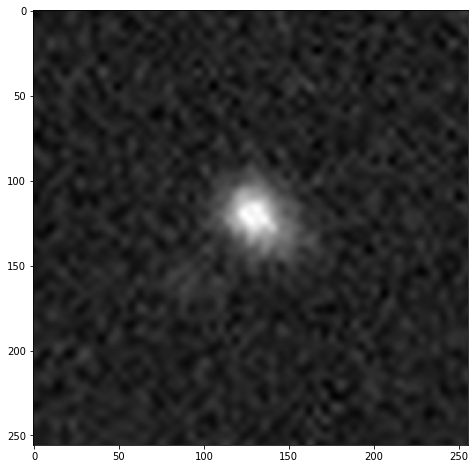

In [6]:
plt.figure(figsize = (8,8))
plt.imshow(bad_image_data[0], cmap='gray') # g band

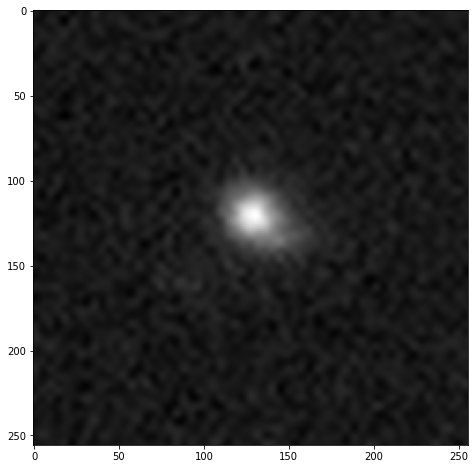

In [7]:
plt.figure(figsize = (8,8))
plt.imshow(bad_image_data[1], cmap='gray') # r band

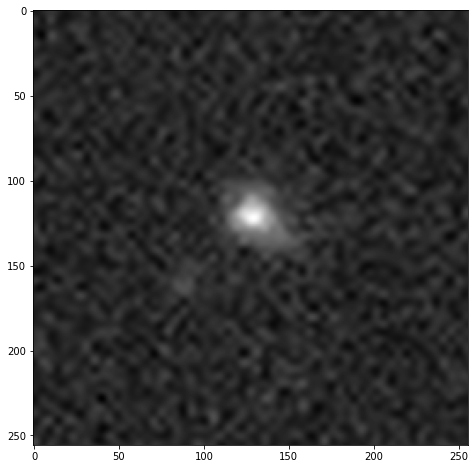

In [8]:
plt.figure(figsize = (8,8))
plt.imshow(bad_image_data[2], cmap='gray') # z band

## Just testing by splitting bands into separate fits files

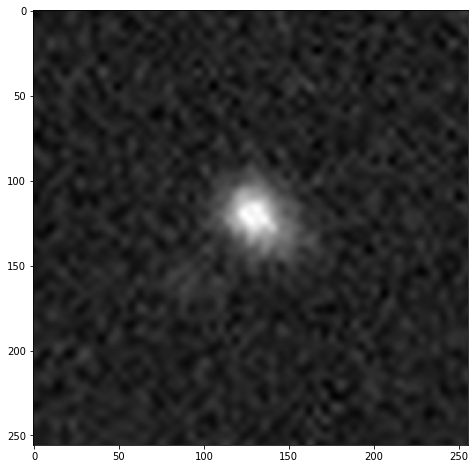

In [9]:
bad_image_data_g = fits.HDUList()

bad_image_data_g.append(fits.ImageHDU(data=bad_image_data[0]))

bad_image_data_g.writeto('/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/g-bad_image_data.fits',
                         overwrite = True)

bad_image_g = fits.getdata('/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/g-bad_image_data.fits',0)

plt.figure(figsize = (8,8))
plt.imshow(bad_image_g, cmap='gray')

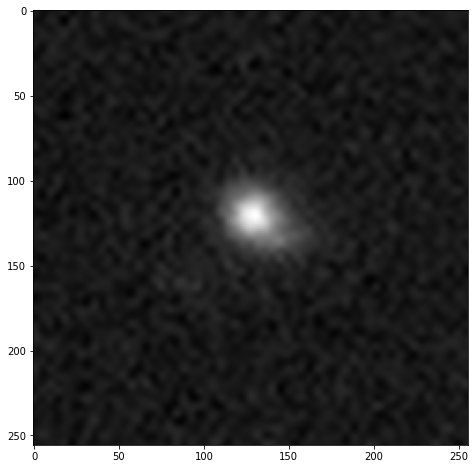

In [10]:
bad_image_data_r = fits.HDUList()

bad_image_data_r.append(fits.ImageHDU(data=bad_image_data[1]))

bad_image_data_r.writeto('/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/r-bad_image_data.fits',
                         overwrite = True)

bad_image_r = fits.getdata('/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/r-bad_image_data.fits',0)

plt.figure(figsize = (8,8))
plt.imshow(bad_image_r, cmap='gray')

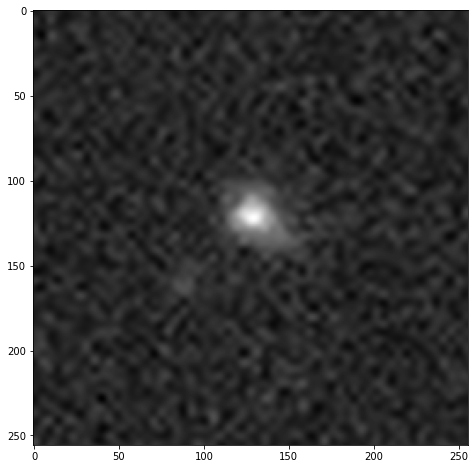

In [11]:
bad_image_data_z = fits.HDUList()

bad_image_data_z.append(fits.ImageHDU(data=bad_image_data[2]))

bad_image_data_z.writeto('/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/z-bad_image_data.fits',
                         overwrite = True)

bad_image_z = fits.getdata('/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/z-bad_image_data.fits',0)

plt.figure(figsize = (8,8))
plt.imshow(bad_image_z, cmap='gray')

#### g-band

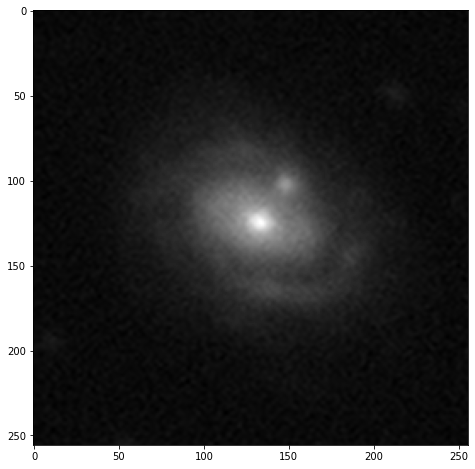

In [12]:
#Good Image
plt.figure(figsize = (8,8))
plt.imshow(good_image_data[0], cmap='gray') #g band

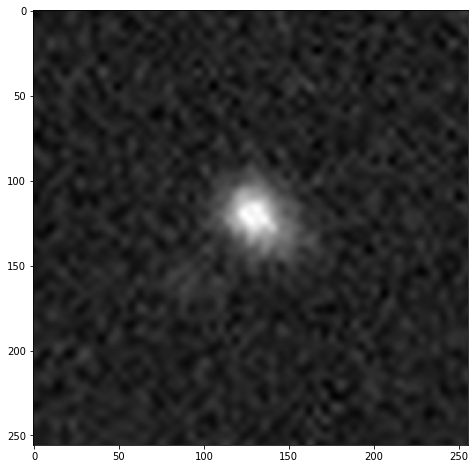

In [13]:
#Bad Image
plt.figure(figsize = (8,8))
plt.imshow(bad_image_data[0], cmap='gray') #g band

#### r-band

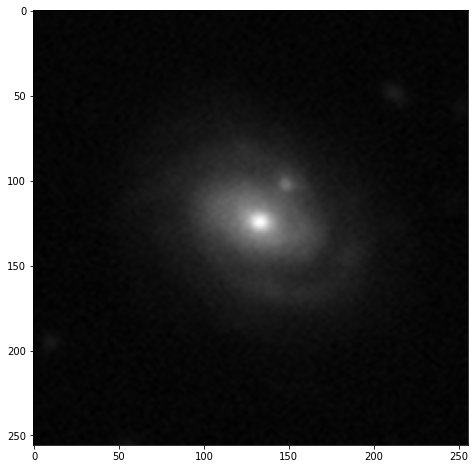

In [14]:
#Good Image
plt.figure(figsize = (8,8))
plt.imshow(good_image_data[1], cmap='gray') #r band

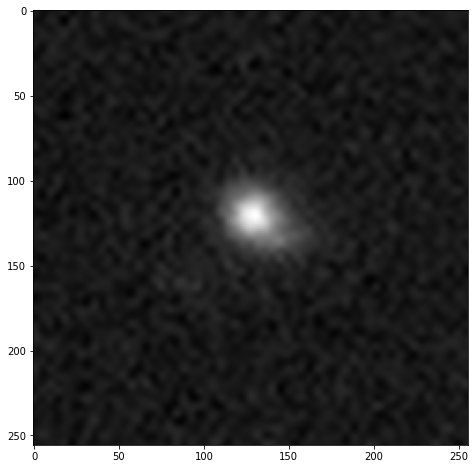

In [15]:
#Bad Image
plt.figure(figsize = (8,8))
plt.imshow(bad_image_data[1], cmap='gray') #r band

#### z-band

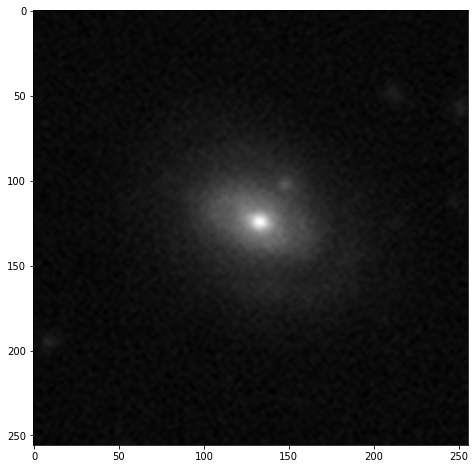

In [16]:
#Good Image
plt.figure(figsize = (8,8))
plt.imshow(good_image_data[2], cmap='gray') #z band

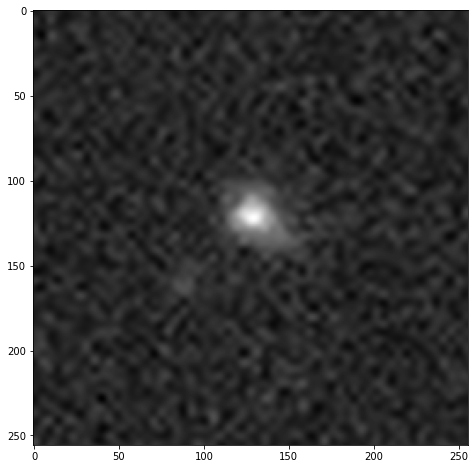

In [17]:
#Bad Image
plt.figure(figsize = (8,8))
plt.imshow(bad_image_data[2], cmap='gray') #z band

### Sigma CLipping

In [18]:
def image_transform_sigma_clipping(img, sigma=3, central=True):
    """
    Applies sigma clipping, fits contours and

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray

    """
    if len(img.shape) > 2:
        im = img[:, :, 0]
    else:
        im = img

    im = np.nan_to_num(im)  # OpenCV can't handle NaNs

    mean, median, std = sigma_clipped_stats(im, sigma=sigma)
    thresh = std + median
    img_bin = np.zeros(im.shape, dtype=np.uint8)

    img_bin[im <= thresh] = 0
    img_bin[im > thresh] = 1

    contours, hierarchy = cv2.findContours(img_bin, 
                                           cv2.RETR_EXTERNAL, 
                                           cv2.CHAIN_APPROX_SIMPLE)

    x0 = img.shape[0] // 2
    y0 = img.shape[1] // 2

    for c in contours:
        if cv2.pointPolygonTest(c, (x0, y0), False) == 1:
            break

    contour_mask = np.zeros_like(img, dtype=np.uint8)
    if len(contours) == 0:
        # This happens if there's no data in the image so we just return zeros
        return contour_mask
    cv2.drawContours(contour_mask, [c], 0, (1, 1, 1), -1)

    new_img = np.zeros_like(img)
    new_img[contour_mask == 1] = img[contour_mask == 1]

    return new_img

In [19]:
clipped_good_image_g = image_transform_sigma_clipping(good_image_data[0], sigma=3, central=True)
clipped_good_image_r = image_transform_sigma_clipping(good_image_data[1], sigma=3, central=True)
clipped_good_image_z = image_transform_sigma_clipping(good_image_data[2], sigma=3, central=True)

In [20]:
clipped_bad_image_g = image_transform_sigma_clipping(bad_image_data[0], sigma=3, central=True)
clipped_bad_image_r = image_transform_sigma_clipping(bad_image_data[1], sigma=3, central=True)
clipped_bad_image_z = image_transform_sigma_clipping(bad_image_data[2], sigma=3, central=True)

### After Clipping

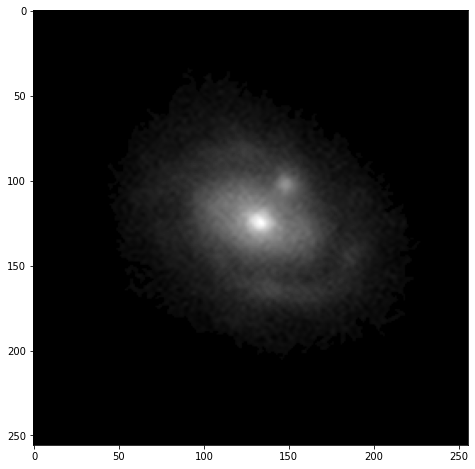

In [21]:
#Good Image G
plt.figure(figsize = (8,8))
plt.imshow(clipped_good_image_g, cmap='gray')

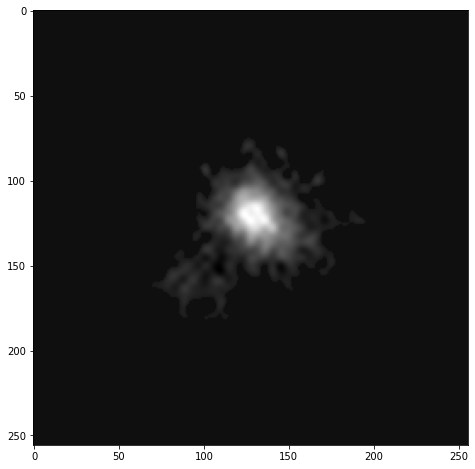

In [22]:
#Bad Image G
plt.figure(figsize = (8,8))
plt.imshow(clipped_bad_image_g, cmap='gray')

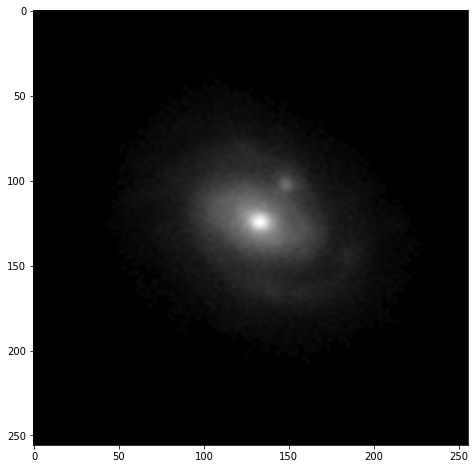

In [23]:
#Good Image r
plt.figure(figsize = (8,8))
plt.imshow(clipped_good_image_r, cmap='gray')

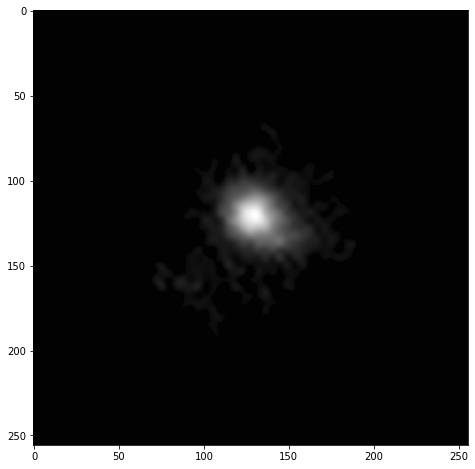

In [24]:
#Bad Image r
plt.figure(figsize = (8,8))
plt.imshow(clipped_bad_image_r, cmap='gray')

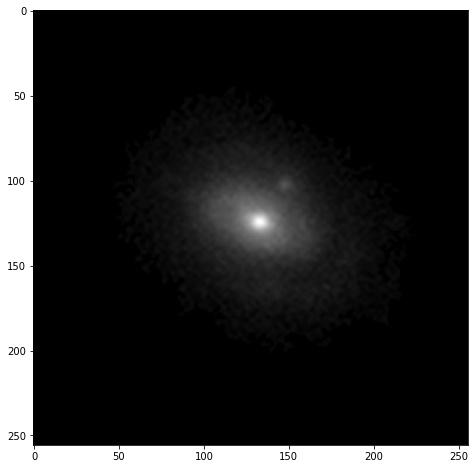

In [25]:
#Good Image z
plt.figure(figsize = (8,8))
plt.imshow(clipped_good_image_z, cmap='gray')

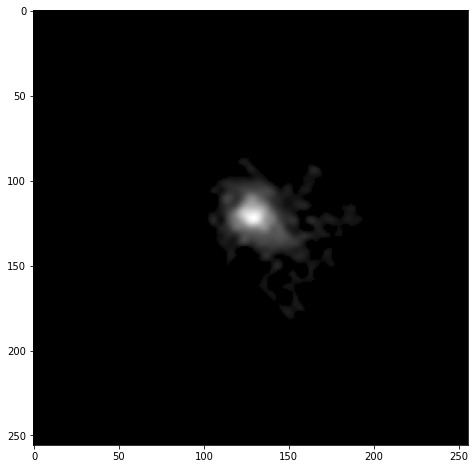

In [26]:
#Bad Image z
plt.figure(figsize = (8,8))
plt.imshow(clipped_bad_image_z, cmap='gray')

### Contours

In [56]:
import numpy as np
import cv2

from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.base import logging_tools


def find_contours(img, threshold):
    """
    Finds the contours of an image that meet a threshold

    Parameters
    ----------
    img : np.ndarray
        Input image (must be greyscale)
    threshold : float
        What threshold to use

    Returns
    -------
    contours
        opencv description of contours (each contour is a list of x,y values
        and there may be several contours, given as a list of lists)
    hierarchy
        opencv description of how contours relate to each other (see opencv 
        documentation)
    """

    img_bin = np.zeros(img.shape, dtype=np.uint8)

    img_bin[img <= threshold] = 0
    img_bin[img > threshold] = 1

    contours, hierarchy = cv2.findContours(img_bin, 
                                           cv2.RETR_EXTERNAL, 
                                           cv2.CHAIN_APPROX_SIMPLE)

    return contours, hierarchy      #Needed to remove this to get it to work

In [61]:
def draw_contour(contour, image, filled=False):
    """
    Draws a contour onto an image for diagnostic purposes

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    filled : bool, optional
        If true will fill in the contour otherwise will return an outline.
    Returns
    -------
    np.ndarray
        The image with the drawn contour on top
    """

    if filled:
        thickness = -1
        contour_arr = np.zeros([image.shape[0], image.shape[1]])
    else:
        thickness = 1
        contour_arr = image.copy()

    ### Needed to use -1 to show all contours, otherwise it does not work properly!!
    cv2.drawContours(contour_arr, contour[0], -1, (1, 1, 1), thickness)

    return contour_arr

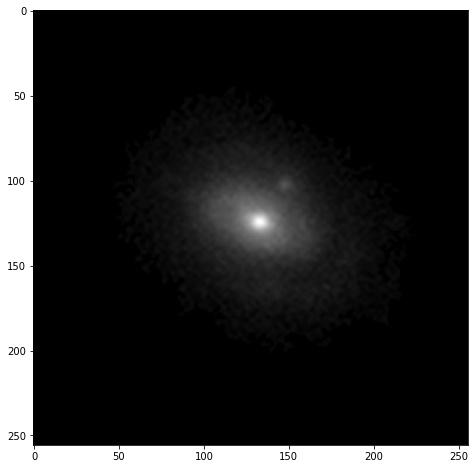

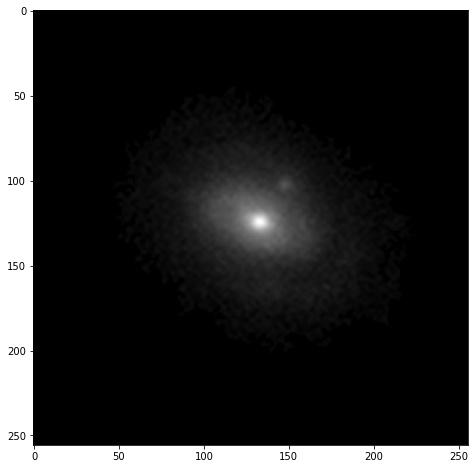

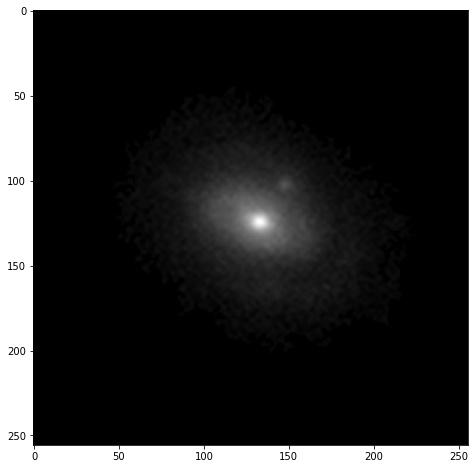

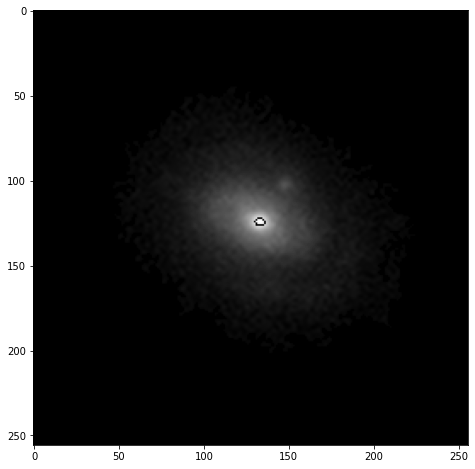

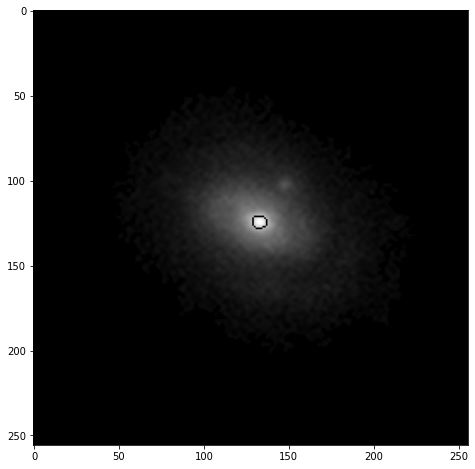

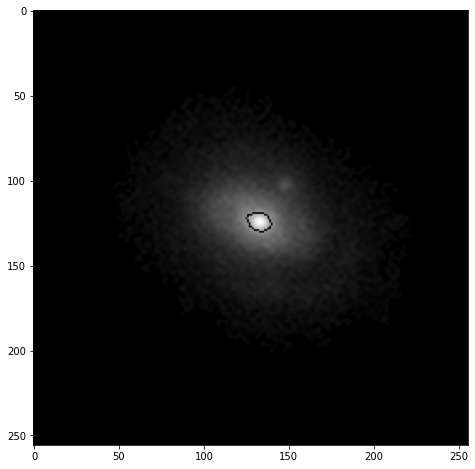

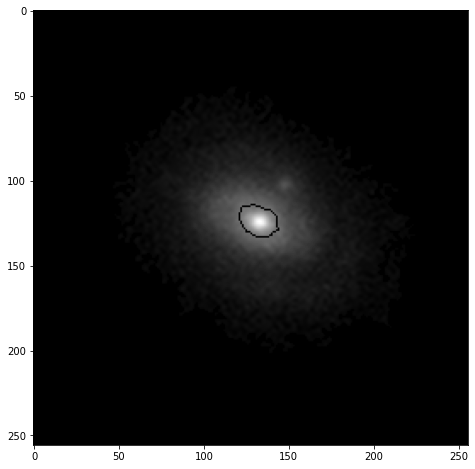

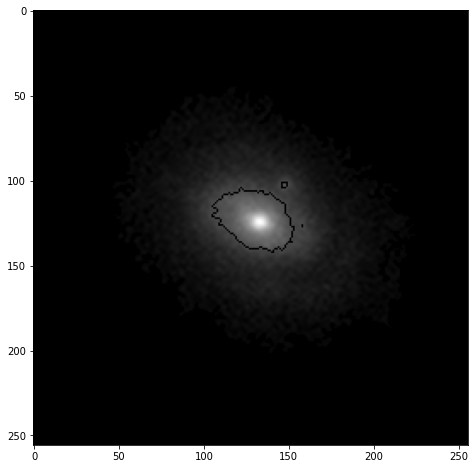

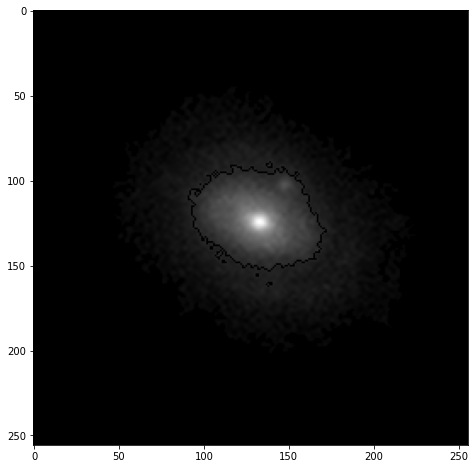

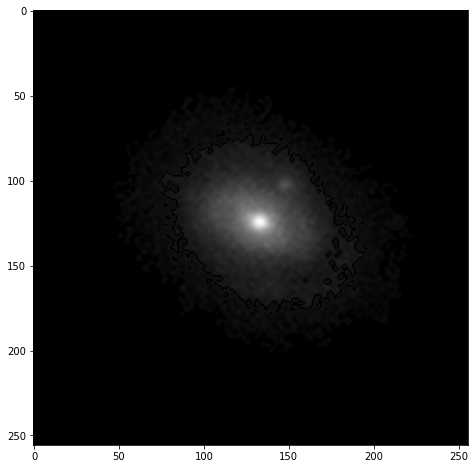

In [217]:
#Good Image z band

image = clipped_good_image_z

percentiles=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

contours = []

for i in percentiles:
    contour_arr = image.copy()
    
    contour = find_contours(image, i)
    contours.append(contour)


d = 0
contours_all = []

for j in range(len(percentiles)):
    contours_drawn = draw_contour(contours[j], image, filled=False)
    contours_all.append(contours_drawn)
    
    plt.figure(figsize = (8,8))
    plt.imshow(contours_drawn, cmap='gray')
    
    #Saving the files as a test
    filename = '/home/verlon/Desktop/Astronomaly/Data/Input/Good Images/Test jpg/Good Image z %d.jpg'%d
    d+=1
    
    plt.imsave(filename, contours_drawn, cmap='gray')

In [53]:
contours_all[8]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

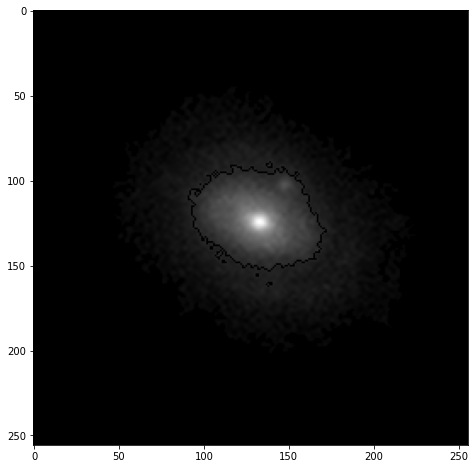

In [55]:
plt.figure(figsize = (8,8))
plt.imshow(contours_all[8], cmap='gray')

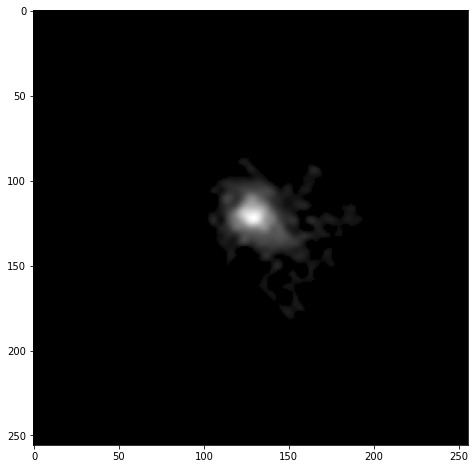

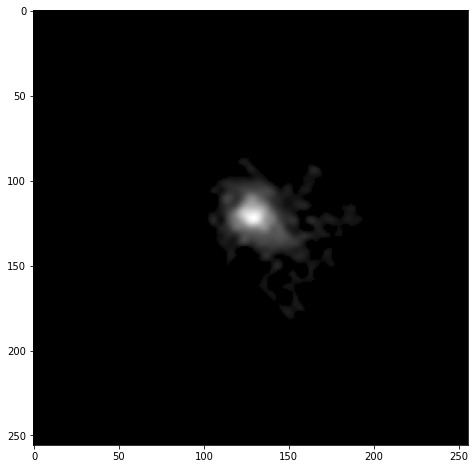

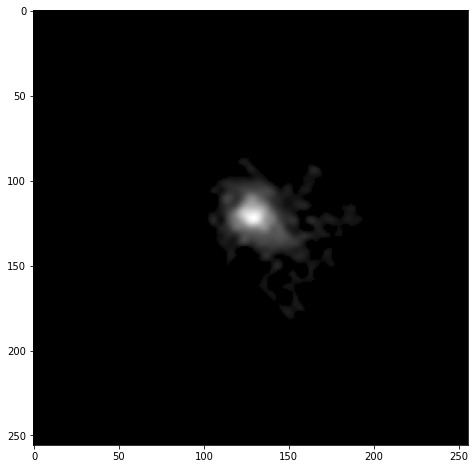

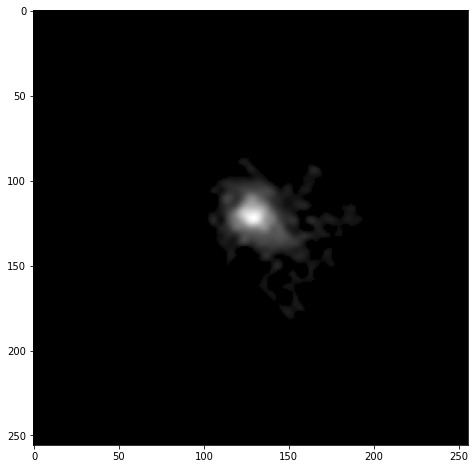

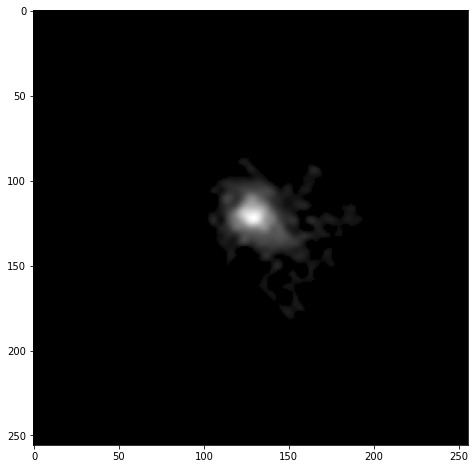

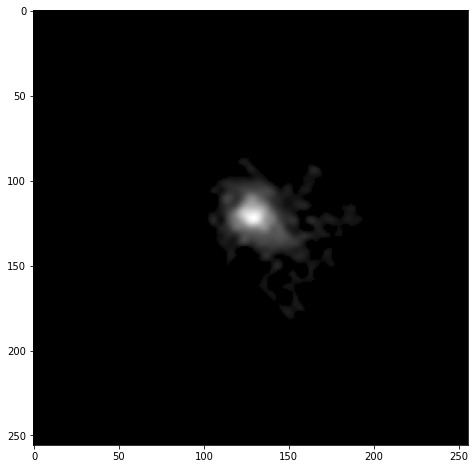

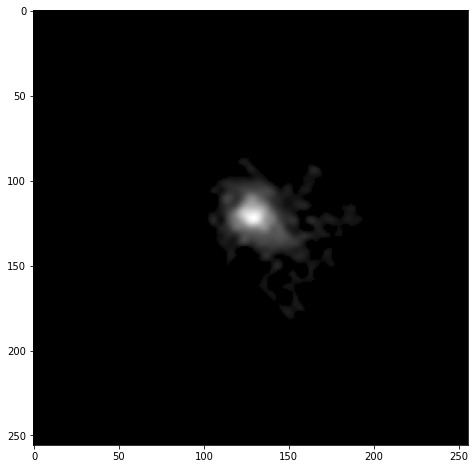

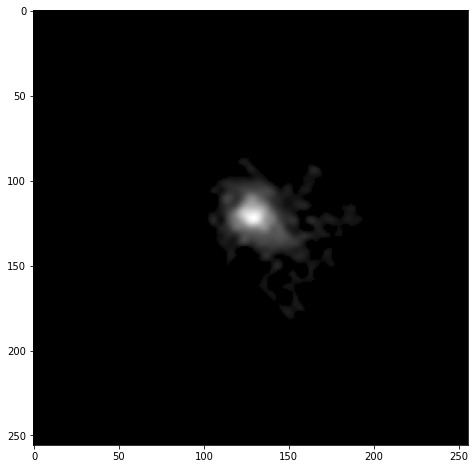

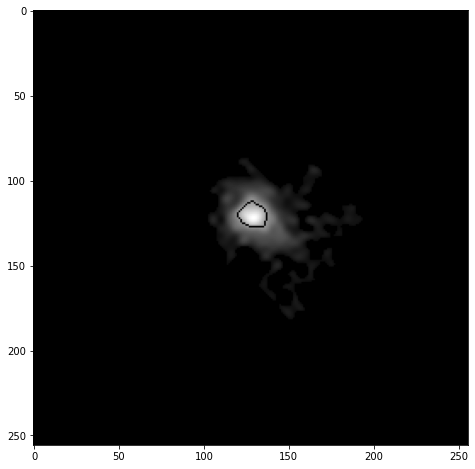

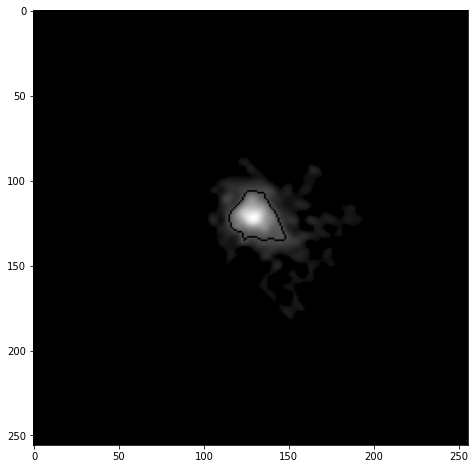

In [51]:
#Bad Image z band

image = clipped_bad_image_z

percentiles=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

contours = []

for i in percentiles:
    contour_arr = image.copy()
    
    contour = find_contours(image, i)
    contours.append(contour)


d = 0
contours_all = []

for j in range(len(percentiles)):
    contours_drawn = draw_contour(contours[j], image, filled=False)
    contours_all.append(contours_drawn)
    
    plt.figure(figsize = (8,8))
    plt.imshow(contours_drawn, cmap='gray')
    
    #Saving the files as a test
    filename = '/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/Test jpg/Bad Image z %d.jpg'%d
    d+=1
    
    plt.imsave(filename, contours_drawn, cmap='gray')

### Just an attempt at displaying the images

import tkinter as tk
from PIL import ImageTk, Image
import glob

win = tk.Tk()
win.geometry('600x600')
win.resizable(0, 0)

panel = tk.Label(win)
panel.pack()

filelist = glob.glob('/home/verlon/Desktop/Astronomaly/Data/Input/Good Images/Test jpg/*.jpg')
images = np.sort(filelist)

images = iter(images)

def next_img():
    try:
        img = next(images)
    except StopIteration:
        return

    img = Image.open(img)
    img = ImageTk.PhotoImage(img)
    panel.img = img
    panel['image'] = img

btn = tk.Button(text='Next image', command=next_img)
btn.pack()

next_img()

win.mainloop()

### Ellipse fitting

In [211]:
def image_transform_sigma_clipping(img, sigma=3, central=True):
    """
    Applies sigma clipping, fits contours and

    Parameters
    ----------
    img : np.ndarray
        Input image

    Returns
    -------
    np.ndarray

    """
    if len(img.shape) > 2:
        im = img[:, :, 0]
    else:
        im = img

    im = np.nan_to_num(im)  # OpenCV can't handle NaNs

    mean, median, std = sigma_clipped_stats(im, sigma=sigma)
    thresh = std + median
    img_bin = np.zeros(im.shape, dtype=np.uint8)

    img_bin[im <= thresh] = 0
    img_bin[im > thresh] = 1

    contours, hierarchy = cv2.findContours(img_bin, 
                                           cv2.RETR_EXTERNAL, 
                                           cv2.CHAIN_APPROX_SIMPLE)

    x0 = img.shape[0] // 2
    y0 = img.shape[1] // 2

    for c in contours:
        if cv2.pointPolygonTest(c, (x0, y0), False) == 1:
            break

    contour_mask = np.zeros_like(img, dtype=np.uint8)
    if len(contours) == 0:
        # This happens if there's no data in the image so we just return zeros
        return contour_mask
    cv2.drawContours(contour_mask, [c], 0, (1, 1, 1), -1)

    new_img = np.zeros_like(img)
    new_img[contour_mask == 1] = img[contour_mask == 1]

    return new_img

In [212]:
import numpy as np
import cv2

from astronomaly.base.base_pipeline import PipelineStage
#from astronomaly.base import logging_tools


def find_contours(img, threshold):
    """
    Finds the contours of an image that meet a threshold

    Parameters
    ----------
    img : np.ndarray
        Input image (must be greyscale)
    threshold : float
        What threshold to use

    Returns
    -------
    contours
        opencv description of contours (each contour is a list of x,y values
        and there may be several contours, given as a list of lists)
    hierarchy
        opencv description of how contours relate to each other (see opencv 
        documentation)
    """

    img_bin = np.zeros(img.shape, dtype=np.uint8)

    img_bin[img <= threshold] = 0
    img_bin[img > threshold] = 1

    contours,hierarchy = cv2.findContours(img_bin, 
                            cv2.RETR_TREE, 
                            cv2.CHAIN_APPROX_SIMPLE)
    
    #contours,hierarchy = cv2.findContours(img_bin, 
    #                            cv2.RETR_EXTERNAL, 
    #                           cv2.CHAIN_APPROX_SIMPLE)
        
    #contours, hierarchy = cv2.findContours(img_bin, 
    #                                       cv2.RETR_EXTERNAL, 
    #                                       cv2.CHAIN_APPROX_SIMPLE)

    return contours#, hierarchy      #Needed to remove this to get it to work

In [213]:
def draw_contour(contour, image, filled=False):
    """
    Draws a contour onto an image for diagnostic purposes

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    filled : bool, optional
        If true will fill in the contour otherwise will return an outline.
    Returns
    -------
    np.ndarray
        The image with the drawn contour on top
    """

    if filled:
        thickness = -1
        contour_arr = np.zeros([image.shape[0], image.shape[1]])
    else:
        thickness = 1
        contour_arr = image.copy()

    #cv2.drawContours(contour_arr, [contour], 0, (1, 1, 1), thickness)   #Needed to change to get it to work
    cv2.drawContours(contour_arr, contour, -1, (1, 1, 1), thickness)

    return contour_arr

In [214]:
def fit_ellipse(contour, image, return_params=False):
    """
    Fits an ellipse to a contour and returns a binary image representation of
    the ellipse.

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    return_params : bool
        If true also returns the parameters of the fitted ellipse

    Returns
    -------
    np.ndarray
        2d binary image with representation of the ellipse
    """

    thickness = -1
    y_npix = image.shape[0]
    x_npix = image.shape[1]
    ellipse_arr = np.zeros([y_npix, x_npix], dtype=np.float)

    # Sets some defaults for when the fitting fails
    default_return_params = [np.nan] * 5 
    raised_error = False

    if len(contour) != 0:
        
        try:
            ((x0, y0), (maj_axis, min_axis), theta) = cv2.fitEllipse(contour[0])
            ellipse_params = x0, y0, maj_axis, min_axis, theta

            if np.any(np.isnan(ellipse_params)):
                raised_error = True
                logging_tools.log('fit_ellipse failed with unknown error:')

        except cv2.error as e:
            logging_tools.log('fit_ellipse failed with cv2 error:' + e.msg)
            raised_error = True

        if raised_error:
            if return_params:
                return ellipse_arr, default_return_params
            else:
                return ellipse_arr
        
    if len(contour) == 0:
        print('No Contour Found')
        return 

    x0 = int(np.round(x0))
    y0 = int(np.round(y0))
    maj_axis = int(np.round(maj_axis))
    min_axis = int(np.round(min_axis))
    theta = int(np.round(theta))

    cv2.ellipse(ellipse_arr, (x0, y0), (maj_axis // 2, min_axis // 2), 
                theta, 0, 360, (1, 1, 1), thickness)

    if return_params:
        return ellipse_arr, ellipse_params
    else:
        return ellipse_arr

In [215]:
image = clipped_good_image_z

percentiles=[0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]

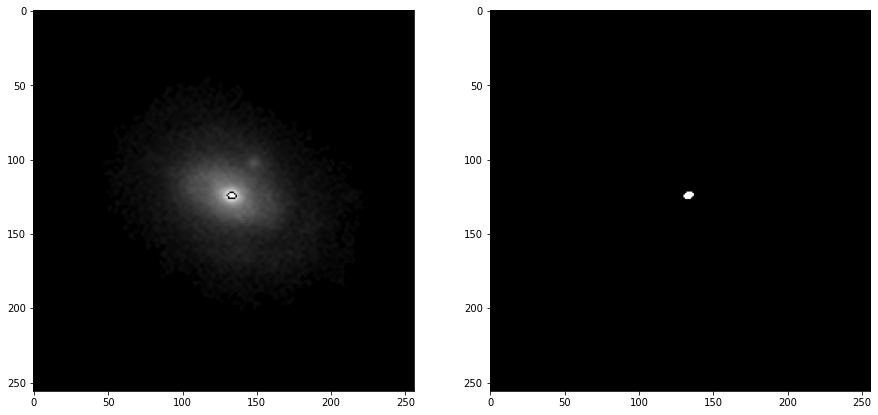

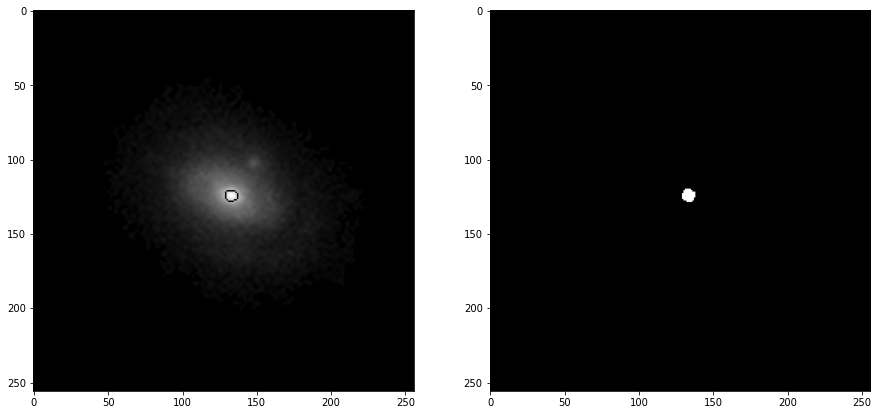

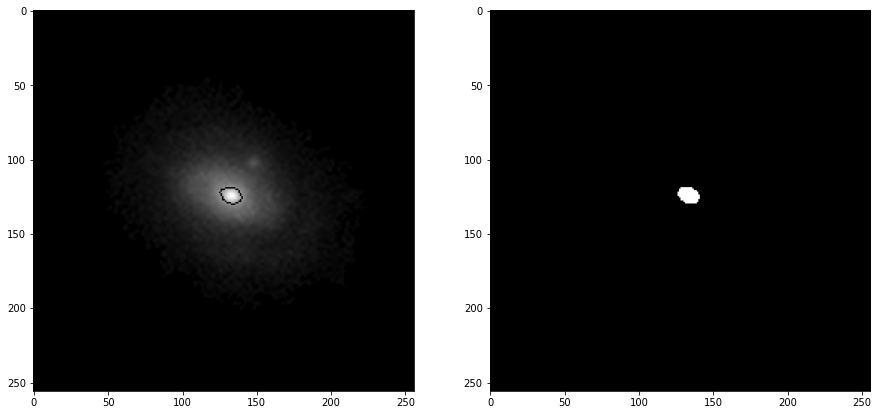

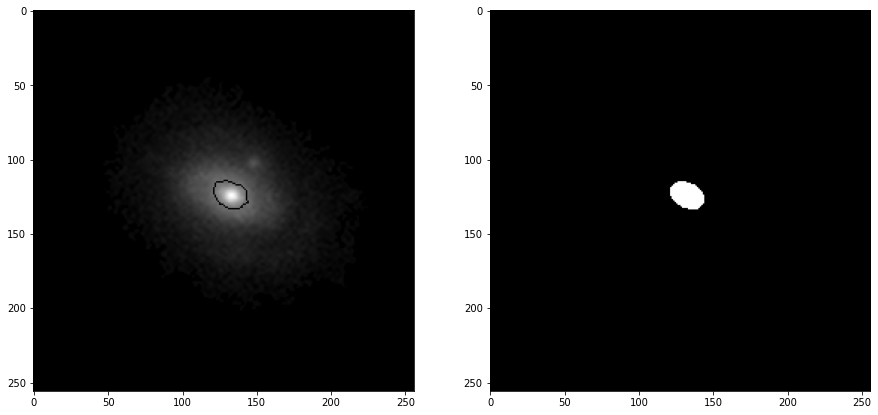

FileNotFoundError: [Errno 2] No such file or directory: ''

In [167]:
#DO NOT TOUCH!!!!


# Finding the contours

contours = []

for i in percentiles:
    
    contour_arr = image.copy()
    contour = find_contours(image, i)
    contours.append(contour)

    
# Drawing the contours and finding the ellipses   

d = 0
contours_all = []
ellipse_parameters = []

for j in range(len(percentiles)):
    
    if len(contours[j]) != 0:
        
        # Determine the contours
        contours_drawn = draw_contour(contours[j], image, filled=False)
        contours_all.append(contours_drawn)
        
        # Fit the Ellipses
        ellipse = fit_ellipse(contours[j], image, return_params=False)
        ellipse_param = fit_ellipse(contours[j], image, return_params=True)[1]
        ellipse_parameters.append(ellipse_param)
        
        # Draw the Images
        f = plt.figure(figsize = (15,15))
        f.add_subplot(1,2, 1)
        plt.imshow(contours_drawn, cmap='gray')
        f.add_subplot(1,2, 2)
        plt.imshow(ellipse, cmap='gray')
        plt.show(block=True)
        
if len(contours[j]) != 0:
    print('No More Contours Found!')
      
  #  Saving the files as a test
  #  filename = '/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/Test jpg/Bad Image z %d.jpg'%d
  #  d+=1
  #  plt.imsave(filename, contours_drawn, cmap='gray')

In [204]:
import numpy as np
import cv2

from astronomaly.base.base_pipeline import PipelineStage
from astronomaly.base import logging_tools


def find_contours(img, threshold):
    """
    Finds the contours of an image that meet a threshold

    Parameters
    ----------
    img : np.ndarray
        Input image (must be greyscale)
    threshold : float
        What threshold to use

    Returns
    -------
    contours
        opencv description of contours (each contour is a list of x,y values
        and there may be several contours, given as a list of lists)
    hierarchy
        opencv description of how contours relate to each other (see opencv 
        documentation)
    """

    img_bin = np.zeros(img.shape, dtype=np.uint8)

    img_bin[img <= threshold] = 0
    img_bin[img > threshold] = 1

    contours,hierarchy = cv2.findContours(img_bin, 
                            cv2.RETR_TREE, 
                            cv2.CHAIN_APPROX_SIMPLE)
    
    #contours,hierarchy = cv2.findContours(img_bin, 
    #                            cv2.RETR_EXTERNAL, 
    #                           cv2.CHAIN_APPROX_SIMPLE)
        
    #contours, hierarchy = cv2.findContours(img_bin, 
    #                                       cv2.RETR_EXTERNAL, 
    #                                       cv2.CHAIN_APPROX_SIMPLE)

    return contours#, hierarchy      #Needed to remove this to get it to work

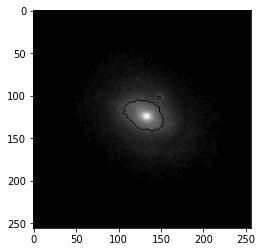

In [208]:
contours[9]
draw_contour(contours[9], image, filled=False)
plt.imshow(contours_drawn, cmap='gray')

In [209]:
np.shape(contours[9])

(47,)

for i in percentiles:
    
    contour_arr = image.copy()
    contour = find_contours(image, i)
    contours.append(contour)

In [229]:
def draw_contour(contour, image, filled=False):
    """
    Draws a contour onto an image for diagnostic purposes

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    filled : bool, optional
        If true will fill in the contour otherwise will return an outline.
    Returns
    -------
    np.ndarray
        The image with the drawn contour on top
    """

    if filled:
        thickness = -1
        contour_arr = np.zeros([image.shape[0], image.shape[1]])
    else:
        thickness = 1
        contour_arr = image.copy()

    #cv2.drawContours(contour_arr, [contour], 0, (1, 1, 1), thickness)   #Needed to change to get it to work
    cv2.drawContours(contour_arr, contour, -1, (1, 1, 1), thickness)
    print(np.shape(contour))

    return contour_arr

In [230]:
def fit_ellipse(contour, image, return_params=False):
    """
    Fits an ellipse to a contour and returns a binary image representation of
    the ellipse.

    Parameters
    ----------
    contour : np.ndarray
        Array of x,y values describing the contours (as returned by opencv's
        findCountours function)
    image : np.ndarray
        The original image the contour was fit to.
    return_params : bool
        If true also returns the parameters of the fitted ellipse

    Returns
    -------
    np.ndarray
        2d binary image with representation of the ellipse
    """

    thickness = -1
    y_npix = image.shape[0]
    x_npix = image.shape[1]
    ellipse_arr = np.zeros([y_npix, x_npix], dtype=np.float)

    # Sets some defaults for when the fitting fails
    default_return_params = [np.nan] * 5 
    raised_error = False

    if len(contour) != 0:
        
        try:
            ((x0, y0), (maj_axis, min_axis), theta) = cv2.fitEllipse(contour[0])
            ellipse_params = x0, y0, maj_axis, min_axis, theta

            if np.any(np.isnan(ellipse_params)):
                raised_error = True
                logging_tools.log('fit_ellipse failed with unknown error:')

        except cv2.error as e:
            logging_tools.log('fit_ellipse failed with cv2 error:' + e.msg)
            raised_error = True

        if raised_error:
            if return_params:
                return ellipse_arr, default_return_params
            else:
                return ellipse_arr
        
    if len(contour) == 0:
        print('No Contour Found')
        return 

    x0 = int(np.round(x0))
    y0 = int(np.round(y0))
    maj_axis = int(np.round(maj_axis))
    min_axis = int(np.round(min_axis))
    theta = int(np.round(theta))

    cv2.ellipse(ellipse_arr, (x0, y0), (maj_axis // 2, min_axis // 2), 
                theta, 0, 360, (1, 1, 1), thickness)

    if return_params:
        return ellipse_arr, ellipse_params
    else:
        return ellipse_arr

(1, 8, 1, 2)


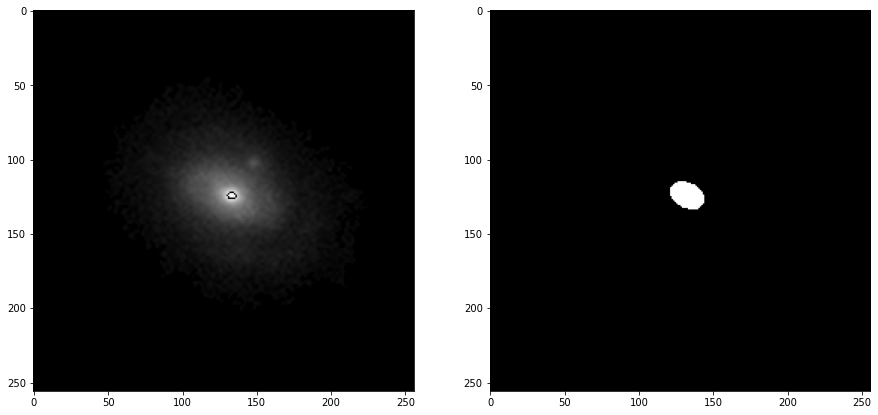

(1, 10, 1, 2)


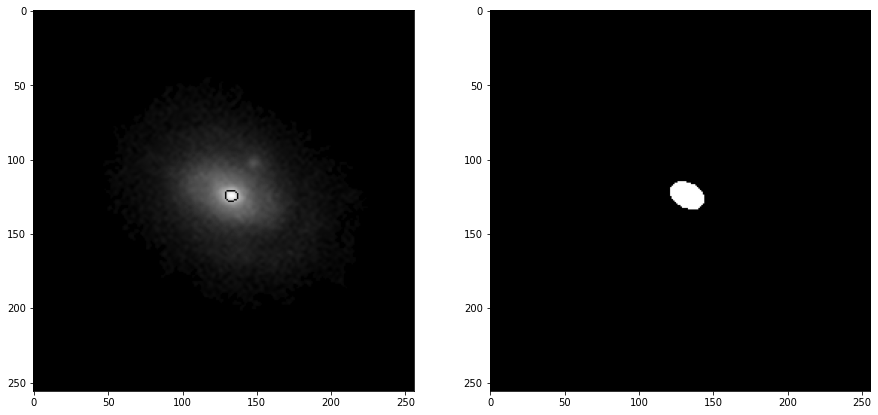

(1, 28, 1, 2)


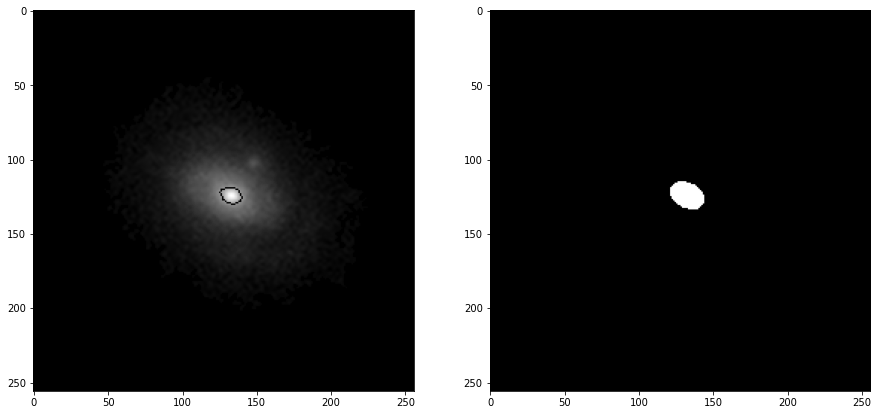

(1, 35, 1, 2)


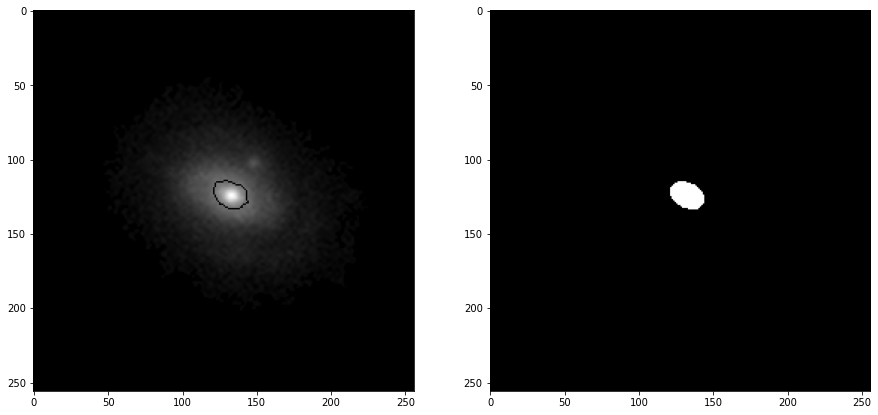

(3,)


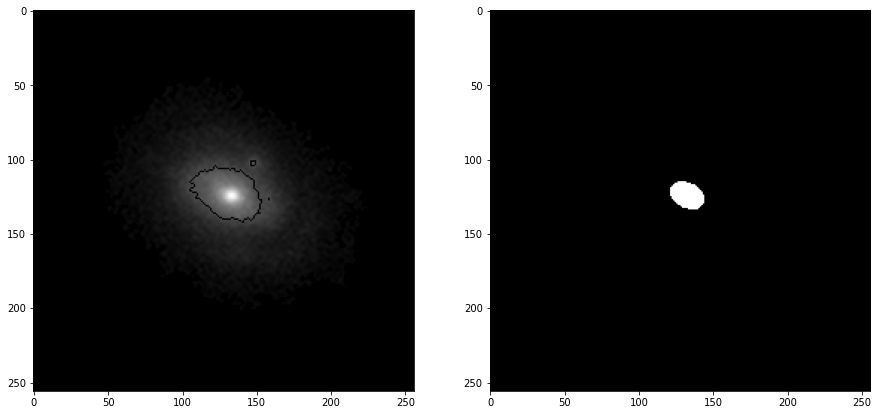

(9,)


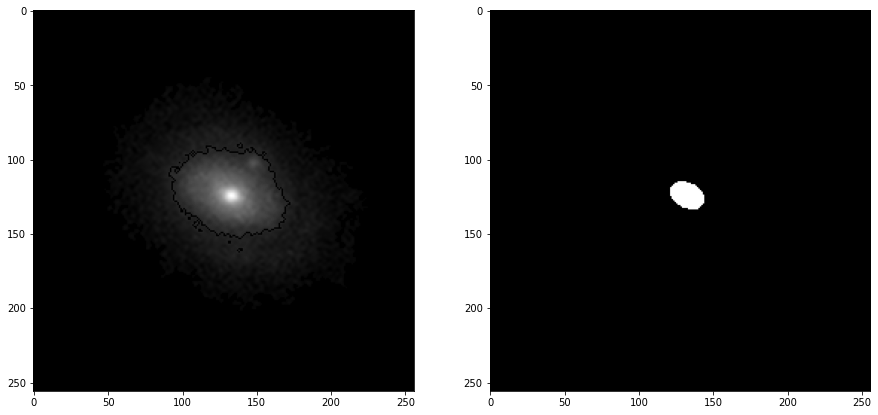

(47,)


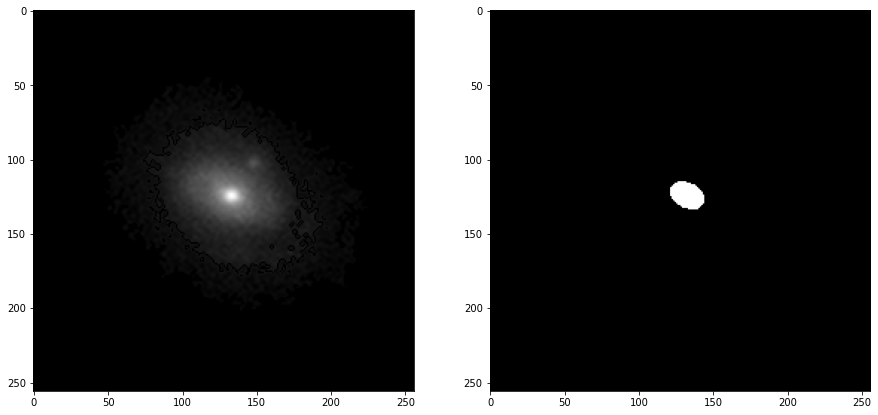

No More Contours Found!


In [232]:
# Finding the contours

contours = []

for i in percentiles:
    
    contour_arr = image.copy()
    contour = find_contours(image, i)
    contours.append(contour)

    
# Drawing the contours and finding the ellipses   

d = 0
contours_all = []
ellipse_parameters = []

for j in range(len(percentiles)):
    
    if len(contours[j]) != 0:
        
        # Determine the contours
        contours_drawn = draw_contour(contours[j], image, filled=False)
        contours_all.append(contours_drawn)
        
  #      # Fit the Ellipses
  #      ellipse = fit_ellipse(contours[j], image, return_params=False)
  #      ellipse_param = fit_ellipse(contours[j], image, return_params=True)[1]
  #      ellipse_parameters.append(ellipse_param)
        
        # Draw the Images
        f = plt.figure(figsize = (15,15))
        f.add_subplot(1,2, 1)
        plt.imshow(contours_drawn, cmap='gray')
        f.add_subplot(1,2, 2)
        plt.imshow(ellipse, cmap='gray')
        plt.show(block=True)
        
if len(contours[j]) != 0:
    print('No More Contours Found!')
      
  #  Saving the files as a test
  #  filename = '/home/verlon/Desktop/Astronomaly/Data/Input/Bad Images/Test jpg/Bad Image z %d.jpg'%d
  #  d+=1
  #  plt.imsave(filename, contours_drawn, cmap='gray')